## Домашняя работа 2


## Данные


В этой домашней работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week

Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать:

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов:
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

## Задание

In [1]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.3 MB/s eta 0:00:00
time: 333 µs (started: 2024-05-15 19:00:48 +00:00)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

SEED = 42

time: 904 ms (started: 2024-05-15 19:00:48 +00:00)


Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [3]:
df = pd.read_csv('/content/data.adult.csv')
df.sample(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
12801,51,State-gov,172022,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,40,>50K
10008,38,Private,195744,Bachelors,13,Never-married,Other-service,Not-in-family,White,Male,0,0,48,<=50K
6735,57,Private,153918,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,<=50K
14175,26,Private,247025,Assoc-voc,11,Divorced,Craft-repair,Own-child,White,Male,0,0,40,<=50K
13311,33,State-gov,43716,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,4,<=50K


time: 262 ms (started: 2024-05-15 19:00:49 +00:00)


Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html).

В данном датасете пропущенные значения обозначены как "?".

**Задание 1** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

In [4]:
df = df[~(df == '?').any(axis=1)].reset_index(drop=True)

time: 57.7 ms (started: 2024-05-15 19:00:49 +00:00)


Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем:

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [5]:
X, y = df.drop('>50K,<=50K', axis=1).select_dtypes('number'), \
       pd.get_dummies(df['>50K,<=50K']).iloc[:, 1].astype(int)

time: 13.9 ms (started: 2024-05-15 19:00:49 +00:00)


## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [SGD Linear Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
 - [GradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Для начала у первых трёх алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)

Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). В качестве схемы кросс-валидации используйте 5-fold cv, которую можно задать с помощью класса [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

**Задание 2** Для каждого из первых трех алгоритмов подберите оптимальные значения указанных гиперпараметров. Для каждого из этих алгоритмов постройте график среднего качества по кросс-валидации при заданном значении гиперпараметра, на котором также отобразите доверительный интервал [m-std, m+std], где m - среднее, std - стандартное отклонение.

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold


N_SPLITS = 5

def optimise_param_kfold(X, y, model, search_params):
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    gscv = GridSearchCV(model, search_params, scoring='roc_auc', cv=kf)
    gscv.fit(X, y)
    return gscv

def plot_mean_sd(ax, x, y_mean, y_std, x_cat=False):
    lower_bound = y_mean - y_std
    upper_bound = y_mean + y_std

    ax.plot(x, y_mean, '-')
    if not x_cat:
        max_x = x[np.argmax(y_mean)]
        ax.axvline(max_x, linestyle='--', color='black')
        plt.xticks(list(plt.xticks()[0]) + [max_x])
    else:
        ax.tick_params(labelrotation = 10)
    ax.fill_between(x, lower_bound, upper_bound, alpha=.3)

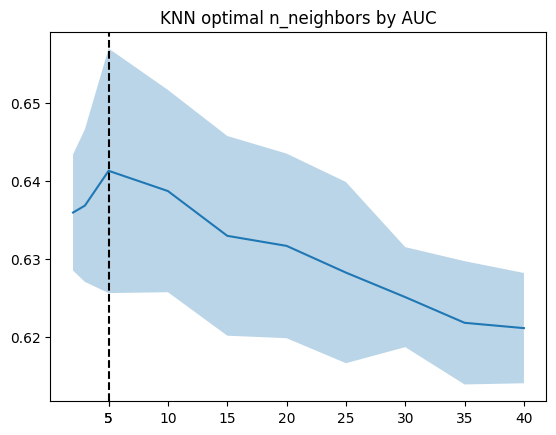

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
params = {'n_neighbors': [2, 3, 5, 10, 15, 20, 25, 30, 35, 40]}
gscv = optimise_param_kfold(X, y, model, params)

fig, ax = plt.subplots()
plot_mean_sd(ax, params['n_neighbors'], gscv.cv_results_['mean_test_score'], gscv.cv_results_['std_test_score'])
ax.set_title('KNN optimal n_neighbors by AUC');

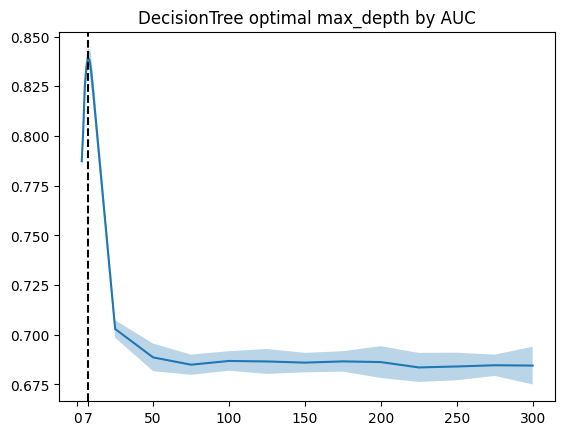

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
params = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]}
gscv = optimise_param_kfold(X, y, model, params)

fig, ax = plt.subplots()
plot_mean_sd(ax, params['max_depth'], gscv.cv_results_['mean_test_score'], gscv.cv_results_['std_test_score'])
ax.set_title('DecisionTree optimal max_depth by AUC');

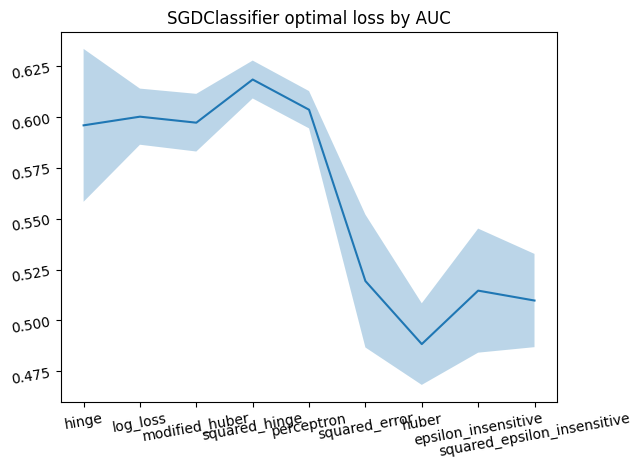

In [ ]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier()
params = {'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']}
gscv = optimise_param_kfold(X, y, model, params)

fig, ax = plt.subplots()
plot_mean_sd(ax, params['loss'], gscv.cv_results_['mean_test_score'], gscv.cv_results_['std_test_score'], x_cat=True)
ax.set_title('SGDClassifier optimal loss by AUC');

В случае KNN после пика мы видим стабильное ухудшение скора, посколько все большее и большее объединение различных соседей ведет к все большему стиранию границ между классами.

В DecisionTreeClassifier судя по всему мы очень сильно переобучаемся уже на небольшой глубине дерева, после чего модель полностью теряет обобщающую способность, или же сваливается в локальный минимум, предсказывая один и тот же класс.

Что вы можете сказать о получившихся графиках?

**Задание 3** Также подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев, так что при увеличении этого гиперпараметра его качество не будет становиться хуже. Поэтому подберите такое количество деревьев, при котором качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества разных размеров, состоящие из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте это количество деревьев.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from collections import defaultdict

n_estimators_vals = np.arange(1, 200, 1)
models_preds = defaultdict(list)

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
for i, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    base_model = RandomForestClassifier(n_estimators=200, random_state=SEED).fit(
        X.iloc[train_idx].to_numpy(), y.iloc[train_idx])
    for n_est in n_estimators_vals:
        preds = np.mean([tree.predict_proba(X.iloc[test_idx].to_numpy())[:, 1] for tree in base_model.estimators_[:n_est]], axis=0)
        score = roc_auc_score(y.iloc[test_idx], preds)
        models_preds[n_est].append(score)
    print(f'Fitted fold {i}')

Fitted fold 0
Fitted fold 1
Fitted fold 2
Fitted fold 3
Fitted fold 4


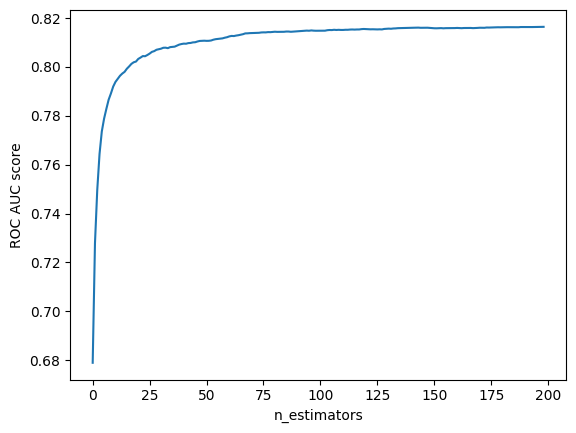

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.array(list(models_preds.values())).mean(axis=1));
ax.set_ylabel('ROC AUC score');
ax.set_xlabel('n_estimators');

Остановимся на 125 деревьях.

Мы использовали предсказания вероятностей лкассов вместо самих классов при подсчете скора, поэтому скор может быть завышен по сравнению с обычной схемой (majority vote составляющих лес деревьев)



**Задание 4** Подберём число деревьев (*n_estimators*) в алгоритме GradientBoosting. Мы знаем, что ошибка бустинга на тестовых данных, как правило, имеет U-образную форму, то есть сначала уменьшается, а при достижении некоторого числа деревьев начинает расти. Нарисуйте график ошибки в зависимости от числа деревьев. Подберите n_estimators, соответствующий минимуму ошибки.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, f1_score
from collections import defaultdict


models_scores = defaultdict(list)

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
for i, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    base_model = GradientBoostingClassifier(n_estimators=1000, random_state=SEED).fit(
        X.iloc[train_idx].to_numpy(), y.iloc[train_idx])

    for j, preds in enumerate(base_model.staged_predict(X.iloc[test_idx].to_numpy())):
        score = roc_auc_score(y.iloc[test_idx], preds)
        models_scores[j].append(score)

    print(f'Fitted fold {i}')

Fitted fold 0
Fitted fold 1
Fitted fold 2
Fitted fold 3
Fitted fold 4


Best number of estimators: 827


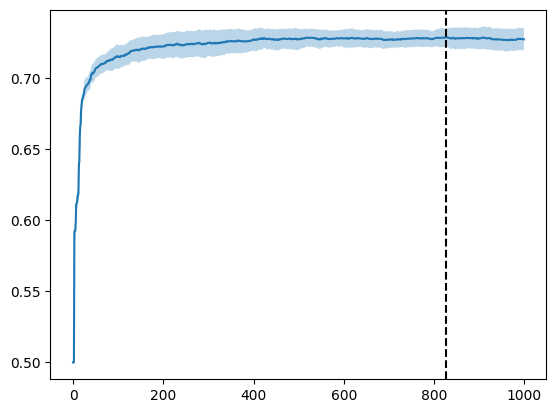

In [ ]:
mean = np.array(list(models_scores.values())).mean(axis=1)
std = np.array(list(models_scores.values())).std(axis=1)
plt.plot(mean)
plt.fill_between(np.arange(0, 1000, 1), mean-std, mean+std, alpha=0.3);
best_num_est = np.arange(0, 1000, 1)[np.argmax(mean)]
plt.axvline(best_num_est, color='black', linestyle='--');
print(f'Best number of estimators: {best_num_est}')

При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**Задание 5** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

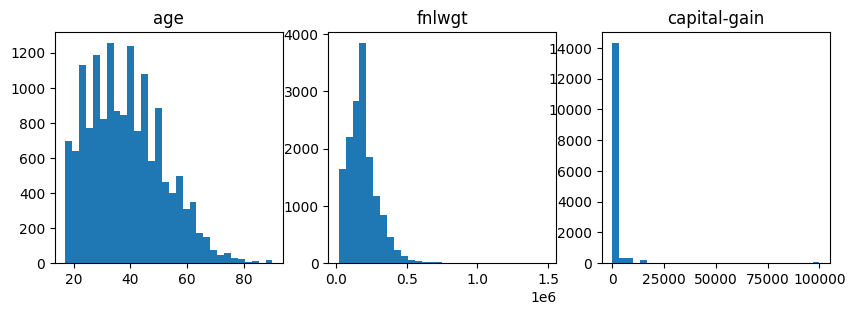

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes = np.ravel(axes)

cols = ['age', 'fnlwgt', 'capital-gain']
for col, ax in zip(cols, axes):
    ax.hist(X[col], bins=30)
    ax.set_title(col)

Разный масштаб признаков может оказать влияние на **KNN**, поскольку он использует абсолютные зачения расстояний между наблюдениями для объединения в классы. Соответственно, бОльшее значение фичи может оказать бОльшее влияние на принадлежность наблюдения к классу.

**SGDClassifier** также пострадает от масштаба. Большое значение признака мождет вылиться в слишком большое обновление весов модели. В результате этого качество может сильно осциллировать, и будет сложнее прийти в локальный минимум.

**DecisionTree** и **RandomForest** не зависят от масштаба признаков. При построении узла дерева учитывается только то, насколько хорошо разделяется таргет. Если скалировать любой признак, то всегда можно построить узел, который даст такое же разделение таргета.

**GradientBoosting** немного зависит от масштаба. С одной стороны, в большинстве случаев мы спользуем деревья решений в качестве базовой модели для бустинга, деревья же от масштаба не зависят. Также, анасамбли внутри бустинга предсказывают не таргет, а ошибку прошлой модели. Размер этой ошибки будет больше в абсолютном значении для больших фичей, соответственно наши веса могут не быть слишком большими.

С другой стороны, в начале обучения большие фичи могут оказывать сильно больший вклад на ошибку, чем маленькие, и модели может потребоваться больше времени что бы сойтись.



Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).

**Задание 6** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

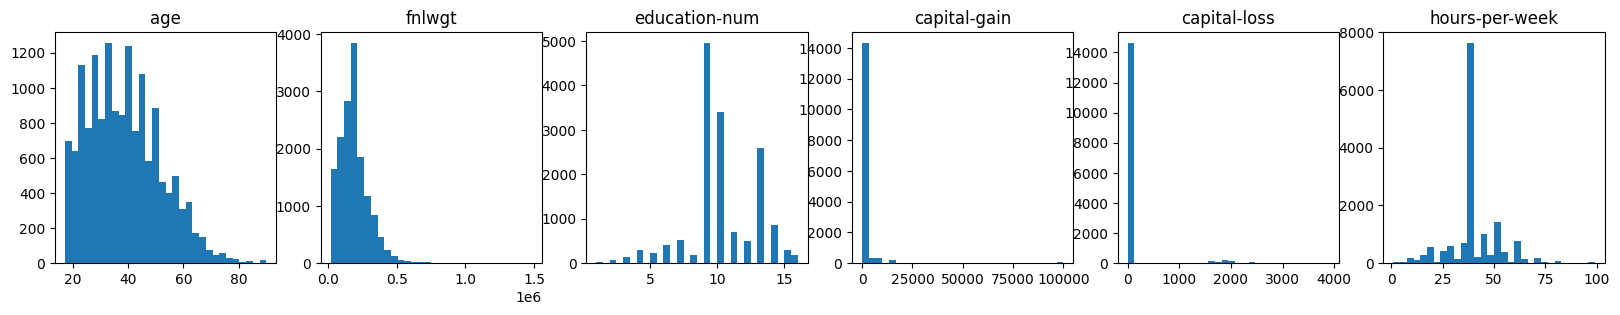

In [ ]:
fig, axes = plt.subplots(1, 6, figsize=(20, 3))
axes = np.ravel(axes)

cols = list(X.columns)
for col, ax in zip(cols, axes):
    ax.hist(X[col], bins=30)
    ax.set_title(col)

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# фичи которые немного похожи на нормальные отскалируем с помощью Stndard Scaler
features = ['age', 'fnlwgt', 'education-num', 'hours-per-week']
standard_scaler = StandardScaler().fit(X[features])
X[features] = standard_scaler.transform(X[features])

# к остальным применим MinMaxScaler
features = ['capital-gain', 'capital-loss']
minmax_scaler = MinMaxScaler().fit(X[features])
X[features] = minmax_scaler.transform(X[features])

time: 1.19 s (started: 2024-05-15 19:01:04 +00:00)


Изменилось ли качество у некоторых алгоритмов?

Мы ожидаем увидели сильное улучшение предсказаний **KNN**, а также улучшение предсказаний **SGDClassifier**.

Для остальных алгоритмов качество не изменилось

**Задание 7** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае:
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - DecisonTree — глубина дерева (*max_depth*) и критерий разбиения (*criterion*)
 - RandomForest — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - GradientBoosting — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*

Обратите внимание, что эта операция может быть ресурсо- и трудоемкой. Как оптимизировать подбор параметров по сетке сказано в разделе "Подбор гиперпараметров модели"

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import roc_auc_score
from itertools import product


def optimise_param_val(X, y, model_class, search_params):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=SEED)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED)

    param_combinations = list(product(*(search_params[param] for param in search_params)))

    best_score = 0
    best_params = None
    best_model = None

    for params in param_combinations:
        param_dict = {param_name: param_value for param_name, param_value in zip(search_params.keys(), params)}
        model = model_class(**param_dict)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        score = roc_auc_score(y_val, y_pred)  # Change to your preferred metric

        # Update best parameters if current score is better
        if score > best_score:
            best_score = score
            best_params = param_dict
            best_model = model

    y_test_pred = best_model.predict(X_test)
    test_score = roc_auc_score(y_test, y_test_pred)

    print(f'Best params: {best_params}')
    print(f'ROC AUC score: {test_score}')

    return best_model, best_params, test_score

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model_class = KNeighborsClassifier
params = {
    'n_neighbors': [2, 3, 5, 10, 15, 20, 25, 30, 35, 40],
    'metric': ['euclidean', 'manhattan', 'cosine']
}
best_model, best_params, score = optimise_param_val(X, y, model_class, params)

Best params: {'n_neighbors': 5, 'metric': 'cosine'}
ROC AUC score: 0.6291113848470073
time: 7.3 s (started: 2024-05-14 15:43:35 +00:00)


In [ ]:
from sklearn.tree import DecisionTreeClassifier


model_class = DecisionTreeClassifier
params = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300],
    'criterion': ['gini', 'entropy', 'log_loss']
}

best_model, best_params, score = optimise_param_val(X, y, model_class, params)

Best params: {'max_depth': 9, 'criterion': 'gini'}
ROC AUC score: 0.708348303265156
time: 3.68 s (started: 2024-05-14 15:43:32 +00:00)


In [ ]:
from sklearn.ensemble import RandomForestClassifier


model_class = RandomForestClassifier
params = {
    'n_estimators': [125],
    'max_features': np.arange(1, 6, 1),
    'criterion': ['gini', 'entropy', 'log_loss']
}

best_model, best_params, score = optimise_param_val(X, y, model_class, params)

Best params: {'n_estimators': 125, 'max_features': 1, 'criterion': 'gini'}
ROC AUC score: 0.7029548506856228
time: 43.9 s (started: 2024-05-14 15:42:47 +00:00)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier


model_class = GradientBoostingClassifier
params = {
    'n_estimators': [827],
    'max_features': np.arange(1, 6, 1),
    'criterion': ['friedman_mse', 'squared_error']
}

best_model, best_params, score = optimise_param_val(X, y, model_class, params)

Best params: {'n_estimators': 827, 'max_features': 4, 'criterion': 'squared_error'}
ROC AUC score: 0.7192389286661363
time: 1min 4s (started: 2024-05-14 15:41:42 +00:00)


In [ ]:
from sklearn.linear_model import SGDClassifier


model_class = SGDClassifier
params = {
    'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty': ['l1', 'l2']
}

best_model, best_params, score = optimise_param_val(X, y, model_class, params)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Best params: {'loss': 'modified_huber', 'penalty': 'l2'}
ROC AUC score: 0.6340610858760831
time: 6.8 s (started: 2024-05-14 15:41:30 +00:00)


Какой из алгоритмов имеет наилучшее качество?

**Задание 8 (0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

Даже не смотрят на то что в бустинге мы рамзер решетки параметров был сильно меньше, он работает дольше всего. На это есть несколько причин:

1. Бустинг требует больше всего вычислительных затрат, ведь для каждой вложенной модели (у нас их 827) мы заново решаем задачу оптимизации.

2. Если сравнивать бустинг с другими "древесными" моделями, вывод напрашивается сам собой: в случае Decision Tree у нас есть одно, возможно сложное, дерево. В случае RandomForest У нас есть много простоых деревьев. В случае с бустингом у нас много сложных деревьев, которые плюс ко всему нельзя распараллелить, как RandomForest.

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков.

**Задание 9** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [8]:
categorical_columns = df.select_dtypes('object').drop('>50K,<=50K', axis=1).columns

# One-hot encode the categorical columns
df_encoded = pd.get_dummies(df[categorical_columns], columns=categorical_columns).astype(int)
X = pd.concat([df_encoded, X], axis=1)
df_best_colsample = X.copy()

time: 25.6 ms (started: 2024-05-15 19:02:35 +00:00)


In [ ]:
X.sample(5)

,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,...,race_Other,race_White,sex_Female,sex_Male,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
1365,0,0,1,0,0,0,0,0,0,0,...,0,1,0,1,0.419879,0.069531,1.116020,0.072981,0.0,-0.074178
9701,0,0,1,0,0,0,0,1,0,0,...,0,1,1,0,-0.800597,1.161289,-1.625894,0.000000,0.0,-0.074178
333,0,0,1,0,0,0,0,0,1,0,...,0,1,1,0,-1.563395,-0.301284,-1.234192,0.000000,0.0,-0.905379
3456,0,0,1,0,0,0,0,0,0,0,...,0,1,1,0,-0.495478,-0.671517,-0.450788,0.000000,0.0,-0.489778
7506,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,-0.648038,0.015697,-0.059086,0.000000,0.0,-0.074178


time: 62.8 ms (started: 2024-05-14 19:01:38 +00:00)


**Задание 10** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [ ]:
from sklearn.model_selection import cross_val_score


def cross_eval(X, y, model_class, model_params):
    model = model_class(**model_params)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
    mean_score = scores.mean()
    return mean_score

time: 979 µs (started: 2024-05-14 19:10:33 +00:00)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model_class = KNeighborsClassifier
params = {
    'n_neighbors': 5,
    'metric': 'cosine'
}

score = cross_eval(X, y, model_class, params)
# previous score 0.69
print(f'Score with new features: {score}')

Score with new features: 0.8399413337788767
time: 6.66 s (started: 2024-05-14 19:11:39 +00:00)


In [ ]:
from sklearn.tree import DecisionTreeClassifier

model_class = DecisionTreeClassifier
params = {
    'max_depth': 9,
    'criterion': 'gini'
}

score = cross_eval(X, y, model_class, params)
# previous score 0.7
print(f'Score with new features: {score}')

Score with new features: 0.886149649352796
time: 673 ms (started: 2024-05-14 19:10:35 +00:00)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_class = RandomForestClassifier
params = {
    'n_estimators': 125,
    'max_features': 1,
    'criterion': 'gini'
}

score = cross_eval(X, y, model_class, params)
# previous score 0.7
print(f'Score with new features: {score}')

Score with new features: 0.8890232768953098
time: 8.5 s (started: 2024-05-14 19:12:40 +00:00)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

model_class = GradientBoostingClassifier
params = {
    'n_estimators': 827,
    'max_features': 4,
    'criterion': 'squared_error'
}

score = cross_eval(X, y, model_class, params)
# previous score 0.72
print(f'Score with new features: {score}')

Score with new features: 0.9196765895378519
time: 27.7 s (started: 2024-05-14 19:13:36 +00:00)


In [ ]:
from sklearn.linear_model import SGDClassifier

model_class = SGDClassifier
params = {
    'loss': 'modified_huber',
    'penalty': 'l2'
}

score = cross_eval(X, y, model_class, params)
# previous score 0.63
print(f'Score with new features: {score}')

Score with new features: 0.891440965630865
time: 2.51 s (started: 2024-05-14 19:14:38 +00:00)


Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

GradientBoosting по прежнему показывает наилучший результат; для всех алгоритмов скоры сильно выросли

## Поиск новых полезных признаков

**Задание 11** Попробуем улучшить качество модели, добавив в неё новые информативные признаки. Поступим так же, как действовали на [семинаре](https://github.com/Murcha1990/ML_Econom_2021-2022/blob/main/Семинары/Семинар%207/Seminar7.ipynb):
* добавьте к модели полиномиальных признаков степени 2 (для создания полиномиальных признаков используйте только исходные числовые признаки)
* затем снизьте размерность с помощью:
a) фильтрационных методов
b) жадного отбора признаков (RFE)
с) встроенного в модель метода отбора признаков.

Для каждого пункта выше выберите один метод и подберите для него оптимальные гиперпараметры, а также количество финальных признаков (по кросс-валидации).

* Затем можно добавить к модели закодированные в предыдущем пункте категориальные признаки.

Позволил ли этот подход улучшить качество моделей?

In [27]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, include_bias=False)
poly.fit(df.select_dtypes('number'))

df_poly = pd.DataFrame(poly.transform(df.select_dtypes('number')), columns=poly.get_feature_names_out())
X = pd.concat([df_encoded, df_poly], axis=1)

time: 16.7 ms (started: 2024-05-15 17:38:22 +00:00)


#### Отбор признаков с помощью фильтрационных методов

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier


# Отбор признаков с помощью фильтрационных методов
gs = GridSearchCV(
    make_pipeline(
        SelectKBest(score_func=mutual_info_classif),
        DecisionTreeClassifier()
    ),
    cv=5,
    param_grid={
        'selectkbest__k': np.arange(6, X.shape[1], 5),
        'decisiontreeclassifier__max_depth': np.arange(1, 20, 4),
        'decisiontreeclassifier__criterion': ['gini', 'entropy', 'log_loss']
    }
)

gs.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function mutual_info_classif at 0x7ad2715c4940>)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy',
                                                               'log_loss'],
                         'decisiontreeclassifier__max_depth': array([ 1,  5,  9, 13, 17]),
                         'selectkbest__k': array([ 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81])})

time: 1h 12min 9s (started: 2024-05-15 07:55:39 +00:00)


In [ ]:
print(dict((k, gs.best_estimator_.get_params()[k]) for k in ['selectkbest__k', 'decisiontreeclassifier__criterion', 'decisiontreeclassifier__max_depth']))
print(f'Model score: {gs.best_score_}')

{'selectkbest__k': 31, 'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 9}
Model score: 0.8476575781987151
time: 8.08 ms (started: 2024-05-15 09:07:48 +00:00)


#### Жадный отбор признаков (RFE)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


# Отбор признаков с помощью RFE
gs = GridSearchCV(
    make_pipeline(
        RFE(LogisticRegression(max_iter=2000), step=30),
        DecisionTreeClassifier()
    ),
    cv=5,
    param_grid={
        'rfe__n_features_to_select': np.arange(6, X.shape[1], 5),
        'decisiontreeclassifier__max_depth': np.arange(1, 20, 4),
        'decisiontreeclassifier__criterion': ['gini', 'entropy', 'log_loss']
    }
)

gs.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rfe',
                                        RFE(estimator=LogisticRegression(max_iter=2000),
                                            step=30)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy',
                                                               'log_loss'],
                         'decisiontreeclassifier__max_depth': array([ 1,  5,  9, 13, 17]),
                         'rfe__n_features_to_select': array([ 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81])})

time: 10min 46s (started: 2024-05-15 07:29:49 +00:00)


In [ ]:
print(dict((k, gs.best_estimator_.get_params()[k]) for k in ['rfe__n_features_to_select', 'decisiontreeclassifier__criterion', 'decisiontreeclassifier__max_depth']))
print(f'Model score: {gs.best_score_}')

{'rfe__n_features_to_select': 76, 'decisiontreeclassifier__criterion': 'log_loss', 'decisiontreeclassifier__max_depth': 9}
Model score: 0.8456375884515005
time: 2.98 ms (started: 2024-05-15 07:40:36 +00:00)


#### Встроенный метод отбора признаков

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier


# Отбор признаков с помощью встроенного метода
gs = GridSearchCV(
    make_pipeline(
        SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')),
        DecisionTreeClassifier()
    ),
    cv=5,
    param_grid={
        'selectfrommodel__threshold': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
        'decisiontreeclassifier__max_depth': np.arange(1, 20, 4),
        'decisiontreeclassifier__criterion': ['gini', 'entropy', 'log_loss']
    }
)

gs.fit(df_poly, y)

In [ ]:
print(dict((k, gs.best_estimator_.get_params()[k]) for k in ['selectfrommodel__threshold', 'decisiontreeclassifier__criterion', 'decisiontreeclassifier__max_depth']))
print(f'Model score: {gs.best_score_}')

## Смешивание моделей

Во всех предыдущих пунктах мы получили много сильных моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и случайный лес). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**Задание 12** Подберите по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и постройте график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"). Дал ли этот подход прирост к качеству по сравнению с моделями ранее?

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from collections import defaultdict


models_scores = defaultdict(list)

for alpha in np.arange(0, 1, 0.1):
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    for i, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        model1 = GradientBoostingClassifier(n_estimators=827, max_features=4, criterion='squared_error')
        model2 = RandomForestClassifier(n_estimators=125, max_features=1, criterion='gini')
        models = [model1, model2]

        ensemble_preds = []
        for model in models:
            model.fit(X.iloc[train_idx], y.iloc[train_idx])
            ensemble_preds.append(model.predict(X.iloc[test_idx]))

        fold_preds = alpha * ensemble_preds[0] + (1-alpha) * ensemble_preds[1]
        fold_score = roc_auc_score(y.iloc[test_idx], fold_preds)
        models_scores[alpha].append(fold_score)

    print(f'Fitted for apha={round(alpha, 1)}')

Fitted for apha=0.0
Fitted for apha=0.1
Fitted for apha=0.2
Fitted for apha=0.3
Fitted for apha=0.4
Fitted for apha=0.5
Fitted for apha=0.6
Fitted for apha=0.7
Fitted for apha=0.8
Fitted for apha=0.9
time: 4min 29s (started: 2024-05-15 17:38:50 +00:00)


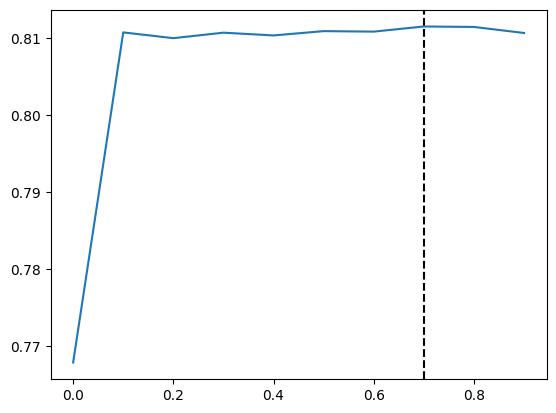

time: 244 ms (started: 2024-05-15 17:46:44 +00:00)


In [34]:
x_alpha = [round(k, 1) for k in models_scores.keys()]
y_score = [np.array(v).mean() for v in models_scores.values()]
plt.plot(x_alpha, y_score);
plt.axvline(x_alpha[np.argmax(y_score)], color='black', linestyle='--');

In [35]:
np.max(y_score)

0.8115085552861319

time: 5.28 ms (started: 2024-05-15 17:57:26 +00:00)


Максимальный скор достигается при alpha=0.7, но смешанная модель хуже, чем обычная

## Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей хотелось бы сравнить их между собой. Для этого можно построить "ящик с усами" (диаграму размаха). Для этого можно воспользоваться библиотекой [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) или [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

**Задание 13** Для каждого типа классификатора (kNN, DecisionTree, RandomForest, SGD classifier), а так же смешанной модели выберите тот, которых давал наилучшее качество на кросс-валидации (с учетом подобранных гиперпараметров) и постройте диаграмму размаха (все классификаторы должны быть изображены на одном графике).

Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

In [9]:
# ранее по коду отдельно сохранили этот набор колонок
df_best_colsample = df_best_colsample

time: 548 µs (started: 2024-05-15 19:06:20 +00:00)


In [14]:
from sklearn.model_selection import cross_val_score


def cross_eval_scores(X, y, model_class, model_params):
    model = model_class(**model_params)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
    return scores

time: 827 µs (started: 2024-05-15 19:17:51 +00:00)


In [18]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


knn_params = params = {
    'n_neighbors': 5,
    'metric': 'cosine'
}
dt_params = params = {
    'max_depth': 9,
    'criterion': 'gini'
}
rf_params = {
    'n_estimators': 125,
    'max_features': 1,
    'criterion': 'gini'
}
sgd_params = {
    'loss': 'modified_huber',
    'penalty': 'l2'
}
gb_params = {
    'n_estimators': 827,
    'max_features': 4,
    'criterion': 'squared_error'
}

knn_scores = cross_eval_scores(df_best_colsample, y, KNeighborsClassifier, knn_params)
dt_scores = cross_eval_scores(df_best_colsample, y, DecisionTreeClassifier, dt_params)
rf_scores = cross_eval_scores(df_best_colsample, y, RandomForestClassifier, rf_params)
sgd_scores = cross_eval_scores(df_best_colsample, y, SGDClassifier, sgd_params)
gb_scores = cross_eval_scores(df_best_colsample, y, GradientBoostingClassifier, gb_params)

time: 29.5 s (started: 2024-05-15 19:19:12 +00:00)


In [25]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from collections import defaultdict


alpha = 0.7
ens_scores = []

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
for i, (train_idx, test_idx) in enumerate(kf.split(df_best_colsample, y)):
    model1 = GradientBoostingClassifier(**gb_params)
    model2 = RandomForestClassifier(**rf_params)
    models = [model1, model2]

    ensemble_preds = []
    for model in models:
        model.fit(df_best_colsample.iloc[train_idx], y.iloc[train_idx])
        ensemble_preds.append(model.predict(df_best_colsample.iloc[test_idx]))

    fold_preds = alpha * ensemble_preds[0] + (1-alpha) * ensemble_preds[1]
    ens_scores.append(roc_auc_score(y.iloc[test_idx], fold_preds))

time: 24.3 s (started: 2024-05-15 19:29:43 +00:00)


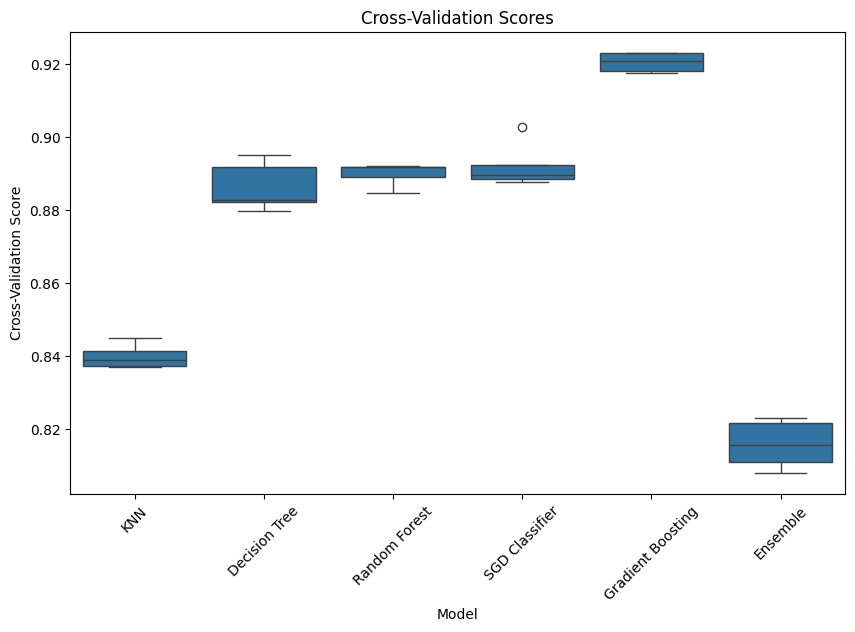

time: 233 ms (started: 2024-05-15 19:35:37 +00:00)


In [31]:
import seaborn as sns

plot_data = {
    'KNN': knn_scores,
    'Decision Tree': dt_scores,
    'Random Forest': rf_scores,
    'SGD Classifier': sgd_scores,
    'Gradient Boosting': gb_scores,
    'Ensemble': ens_scores
}

df_scores = pd.DataFrame(plot_data)

df_melted = df_scores.melt(var_name='Model', value_name='Score')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Score', data=df_melted)
plt.title('Cross-Validation Scores')
plt.xlabel('Model')
plt.ylabel('Cross-Validation Score')
plt.xticks(rotation=45)
plt.show()

Все модели лучше всего показали себя с бинарными фичами. При добавлении полиномиальных фичей и отборе самых значимых, модели стали чуть хуже (даже KNN, который страдает от высоких размерностей), что говорит о том, что отбор признаков в первую очред нужен для ускорения тренировки и интепретируемости.

Gradient Boosting показал себя лучше всего почти во всех задачах, как самая продвинутая и адаптирующаяся модель.

Подбор гиперпараметров помог улучшить скоры во всех моделях (в сравнении с самой базовой версией). Подбор количества фичей сильно замедляет время тренировки модели, особенно в случае со встроенным и жадным методами отбора признаков, добавляя ко времени каждой итерации подбора существенную константу. Для остальных гиперпараметро можно сказать, что время растет строго пропорционально количеству элементов в решетке гиперпараметров, что говорит о том что на практике поиск гиперпараметров по сетке имеет смысл только для очень маленького количества признаков.